# Механизмы внимания и трансформеры

Одним из основных недостатков рекуррентных сетей является то, что все слова в последовательности оказывают одинаковое влияние на результат. Кроме того, для задач sequence-to-sequence, таких как распознавание именованных сущностей и машинный перевод, нам необходимо запомнить всю входную последовательность в единый вектор смысла. В действительности конкретные слова во входной последовательности часто оказывают большее влияние на определённые выходы, чем другие.

Рассмотрим задачу sequence-to-sequence, такую, как машинный перевод. Она реализуется двумя рекуррентными сетями, где одна сеть (**кодировщик**) сворачивает входную последовательность в скрытое состояние, а другая, **декодер**, разворачивает это скрытое состояние в результирующую выходную последовательность. Проблема с этим подходом заключается в том, что конечному состоянию сети будет трудно запомнить начало предложения, что приведет к низкому качеству модели на длинных предложениях.

**Механизмы внимания** позволяют бороться с этой проблемой. Они представляют собой средство взвешивания контекстуального воздействия каждого входного токена на каждое выходное предсказание RNN. Внимание реализуется путем создания связей между промежуточными состояниями энкодера и декодера. Таким образом, при генерации выходного символа $y_t$, мы будем учитывать все входные скрытые состояния $h_i$, с различными весовыми коэффициентами $\alpha_{t,i}$.

![Image showing an encoder/decoder model with an additive attention layer](https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/lessons/5-NLP/18-Transformers/images/encoder-decoder-attention.png)

(Тут показана модель энкодера-декодера с аддитивным механизмом внимания из [Bahdanau et al., 2015](https://arxiv.org/pdf/1409.0473.pdf), цитируемая из [этого сообщения в блоге](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html))

Матрица внимания $\{\alpha_{i,j}\}$ будет определять степень, в которой те или иные входные слова влияют нагенерацию данного слова в выходной последовательности. Ниже приведен пример такой матрицы:

![Image showing a sample alignment found by RNNsearch-50, taken from Bahdanau - arviz.org](https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/lessons/5-NLP/18-Transformers/images/bahdanau-fig3.png)

(Рисунок взят из [Богданау и др., 2015](https://arxiv.org/pdf/1409.0473.pdf) (рис.3))

Все современные подходы к NLP используют механизмы внимания. Однако добавление внимания значительно увеличивает количество параметров модели, что приводит к проблемам масштабирования. Ключевым ограничением масштабирования RNN является то, что рекуррентный характер моделей затрудняет параллельное обучение моделей на кластерах GPU, в то время как размер модели становится настолько большим, что обучать её на одном процессоре становится слишком долго. В RNN каждый элемент последовательности должен быть обработан в последовательном порядке, что означает, что процесс обучения не может быть легко распараллелен.

Внедрение механизмов внимания и преодоление такого ограничения позволило обучать действительно большие модели, такие, как BERT или GPT-3.

## Трансформеры

В отличие от рекуррентных сетей, которые последовательно передают контекст из одного блока в другой, **модели трансформеров** используют **позиционную кодировку** и **внимание**, одновременно рассматривая всё предложение и вычисляя коэффициент внимания между словами входного предложения, и между входным и выходным предложением.

![Animated GIF showing how the evaluations are performed in transformer models.](https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/lessons/5-NLP/18-Transformers/images/transformer-animated-explanation.gif)

Такой процесс, в отличие от последовательного применения рекуррентной сети, может распараллеливаться лучше, что позволяет создавать гораздо более крупные и выразительные языковые модели.

Подробнее про трансформерные модели можно почитать [в этой русскоязычной статье](https://sysblok.ru/knowhow/kak-rabotajut-transformery-krutejshie-nejroseti-nashih-dnej/) (или [здесь](http://jalammar.github.io/illustrated-transformer/) на английском языке).

Важной идеей трансформерных моделей является идея **внутреннего внимания** (*self-attention*). Например, рассмотрим два предложения:

* Chicken did not cross the road because it was too wide
* Chicken did not cross the road because it was too tired

В первом случае слово *it* относится к дороге, а во втором - к цыплёнку. Энкодер предложения должен учитывать это обстоятельство, и механизм внутреннего внимания как раз помогает построить матрицу взаимного влияния токенов друг на друга в рамках входной последовательности.

## Построение простой модели трансформера

Keras не содержит встроенного слоя для трансформеров, но мы можем построить свой собственный. Такой процесс неплохо описан [в документации](https://www.tensorflow.org/text/tutorials/transformer).

Как и прежде, мы сосредоточимся на текстовой классификации набора данных AG News, но стоит отметить, что трансформерные модели показывают наилучший результат и в существенно более сложных задачах NLP.

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np

ds_train, ds_test = tfds.load('ag_news_subset').values()

def extract_text(x):
    return x['title']+' '+x['description']

def tupelize(x):
    return (extract_text(x),x['label'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteBU54TK/ag_news_subset-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteBU54TK/ag_news_subset-test.tfrecord*...:   …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


Новые слои в Keras должны наследовать класс `Layer` и реализовывать метод `call`. Начнем с слоя **позиционного эмбеддинга**, который применяется ко входной последовательности. Мы будем использовать [код из официальной документации Keras](https://keras.io/examples/nlp/text_classification_with_transformer/). Также предположим, что все входные последовательности приведены к длине `maxlen`.

In [ ]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.maxlen = maxlen

    def call(self, x):
        maxlen = self.maxlen
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x+positions

Этот слой состоит из двух слоев `Embedding`: для кодирования токенов (способом, который мы обсуждали ранее) и позиций токенов. Позиции токенов создаются в виде последовательности натуральных чисел от 0 до `maxlen` с помощью `tf.range`, а затем передаются через слой эмбеддинга. Два результирующих эмбеддинг-вектора складываются, что приводит к тензору размерности `maxlen` $\times$ `embed_dim`.

<img src="https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/lessons/5-NLP/18-Transformers/images/pos-embedding.png" width="40%"/>

Отметим, что в более продвинутых трансформерных моделях вместо позиционных эмбеддингов могут использоваться **позиционные кодировки**, представляющие собой некоторые нелинейные функции, не обучаемые, а подбираемые как гиперпараметры.

Теперь давайте реализуем трансформерный блок. В качестве входа он воспринимает выход предыдущего блока позиционного эмбеддинга:

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name='attn')
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Мы используем блок `MultiHeadAttention` для получения вектора внутреннего внимания (*self-attention*) размерности `maxlen` $\times$ `embed_dim` - для этого на вход слою мы подаём одну и ту же последовательность `inputs`. Мы используем приём, аналогичный residual connection в сетях ResNet для стабилизации обучения, смешивая результат внутреннего внимания с входом, и нормализуя его с помощью `LayerNormalizaton`.

> **Примечание**: `LayerNormalization` похож на `BatchNormalization`, но он нормализует выходы предыдущего слоя для каждого обучающего образца независимо друг от друга, чтобы привести их к диапазону [-1..1].

Выход этого слоя затем пропускается через полносвязную сеть (в нашем случае — двухслойный персептрон), и результат добавляется к конечному выходу (который снова проходит нормализацию).

<img src="https://raw.githubusercontent.com/microsoft/AI-For-Beginners/main/lessons/5-NLP/18-Transformers/images/transformer-layer.png" width="30%" />

Теперь мы можем определить полную модель трансформера:

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 256
vocab_size = 20000

model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size,output_sequence_length=maxlen, input_shape=(1,)),
    TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim),
    TransformerBlock(embed_dim, num_heads, ff_dim),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(4, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 256)               0         
 ctorization)                                                    
                                                                 
 token_and_position_embeddi  (None, 256, 32)           648192    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 256, 32)           10656     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                      

In [ ]:
print('Training tokenizer')
model.layers[0].adapt(ds_train.take(15000).map(extract_text))
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='adam')
model.fit(ds_train.map(tupelize).batch(128),validation_data=ds_test.map(tupelize).batch(128))

Training tokenizer
938/938 [==============================] - 72s 67ms/step - loss: 0.4709 - acc: 0.8223 - val_loss: 0.2510 - val_acc: 0.9172


## BERT

**BERT** (Bidirectional Encoder Representations from Transformers) представляет собой большую многослойную трансформерную сеть с 12 слоями для *BERT-base* и 24 - для *BERT-large*. Модель сначала предварительно обучается на большом корпусе текстовых данных (Википедия + книги) с использованием self-supervised learning (прогнозирование замаскированных слов в предложении). Во время предварительного обучения модель приобретает значительный уровень понимания языка в целом, который затем может быть использован с другими наборами данных для решения специфических задач. Этот процесс называется **трансферное обучение**, и хорошо описан [в официальной документации Keras](https://keras.io/examples/nlp/masked_language_modeling/).

Существует множество вариаций предобученных трансформерных архитектур, которые можно использовать для трансферного обучения, включая BERT, DistilBERT, BigBird, OpenGPT3 и другие.

Давайте посмотрим, как мы можем использовать предварительно обученную модель BERT для решения нашей традиционной задачи классификации новостей. Мы позаимствуем идею и некоторый код из [официальной документации](https://www.tensorflow.org/text/tutorials/classify_text_with_bert).

Для загрузки предварительно обученных моделей мы будем использовать **Tensorflow hub**. Загрузим векторизатор, специально обученный  для BERT:

In [ ]:
!pip freeze | grep tensorflow

tensorflow @ https://storage.googleapis.com/colab-tf-builds-public-09h6ksrfwbb9g9xv/tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl#sha256=a2ec79931350b378c1ef300ca836b52a55751acb71a433582508a07f0de57c42
tensorflow-datasets==4.9.4
tensorflow-estimator==2.15.0
tensorflow-gcs-config==2.15.0
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.0
tensorflow-metadata==1.15.0
tensorflow-probability==0.23.0


In [ ]:
!pip install tensorflow_text==2.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.8 MB/s eta 0:00:00


In [ ]:
import tensorflow_text
import tensorflow_hub as hub
vectorizer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [ ]:
vectorizer(['I love transformers'])

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

Важно использовать тот же векторизатор, на котором была обучена исходная сеть. Векторизатор BERT возвращает три компонента:
* `input_word_ids` - последовательность номеров токенов для входного предложения
* `input_mask` показывает, какая часть последовательности содержит фактические входные данные, а какая - padding. Он похож на маску, создаваемую слоем `Masking`
* `input_type_ids` используется для более сложных задач языкового моделирования (например, ответы на вопросы), и позволяет указать два входных предложения в одной последовательности.

Затем мы можем создать экземпляр BERT:

In [ ]:
bert = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1')

In [ ]:
z = bert(vectorizer(['I love transformers']))
for i,x in z.items():
    print(f"{i} -> { len(x) if isinstance(x, list) else x.shape }")

pooled_output -> (1, 128)
encoder_outputs -> 4
sequence_output -> (1, 128, 128)
default -> (1, 128)


Смотрим на то, что возвращает сеть BERT:
* `pooled_output` является результатом усреднения всех векторов последнего слоя. Вы можете рассматривать его как семантический вектор для всей входной последовательности. Он эквивалентен выходу слоя `GlobalAveragePooling1D` в нашей предыдущей модели.
* `sequence_output` - это выход последнего слоя трансформера (соответствует выходу `TransformerBlock` в нашей модели выше)
* `encoder_outputs` - это выходы всех промежуточных слоёв сети. Поскольку мы загрузили 4-слойную модель BERT (как вы, вероятно, можете догадаться из названия, которое содержит «4_H»), этот выход содержит 4 тензора. Последний из них совпадает с `sequence_output`.

Теперь определим сквозную модель классификации. Мы будем использовать *функциональное определение модели* в Keras. Мы также сделаем веса модели BERT необучаемыми и обучим только окончательный классификатор:

In [ ]:
import tensorflow as tf
from tensorflow import keras

inp = keras.Input(shape=(),dtype=tf.string)
x = vectorizer(inp)
x = bert(x)
x = keras.layers.Dropout(0.1)(x['pooled_output'])
out = keras.layers.Dense(4,activation='softmax')(x)
model = keras.models.Model(inp,out)
bert.trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer='adam')
model.fit(ds_train.map(tupelize).batch(128),validation_data=ds_test.map(tupelize).batch(128))

 76/938 [=>............................] - ETA: 8:34 - loss: 1.3515 - acc: 0.3804

Несмотря на то, что обучаемых параметров немного, процесс довольно медленный, потому что экстрактор признаков BERT является весьма сложной моделью. На одной эпохе обучения точность не слишком высока, можно попробовать продолжить обучение, или использовать несколько других приёмов.

Давайте попробуем разморозить веса BERT и тренировать их. Это требует очень малой скорости обучения, а также более тщательной стратегии обучения с **разминкой**, с использованием оптимизатора **AdamW**. Мы будем использовать пакет `tf-models-official` для создания оптимизатора:

In [ ]:
!pip install tf-models-official==2.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=c5e10b2563f6b4f2f6c4660a4c27c76018a8dda3a14b31ea2be8e880ac5abe0f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from official.nlp import optimization
bert.trainable=True
model.summary()
epochs = 3
opt = optimization.create_optimizer(
    init_lr=3e-5,
    num_train_steps=epochs*len(ds_train),
    num_warmup_steps=0.1*epochs*len(ds_train),
    # optimizer_type='adamw')

model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'], optimizer=opt)
model.fit(ds_train.map(tupelize).batch(128),validation_data=ds_test.map(tupelize).batch(128))

Как видите, обучение идет довольно медленно - но вы можете поэкспериментировать и обучить модель в течение нескольких эпох (5-10) и посмотреть, сможете ли вы получить лучший результат по сравнению с подходами, которые мы использовали раньше.

## Библиотека Huggingface Transformers

Другим очень распространенным (и немного более простым) способом использования моделей Transformer является [пакет HuggingFace](https://github.com/huggingface/), который предоставляет своего рода *строительные блоки* для различных задач NLP. Он доступен как для Tensorflow, так и для PyTorch, еще одного очень популярного фреймворка нейронных сетей.

> **Примечание**: Ниже мы будем повторять те же шаги обучения модели BERT с использованием другой библиотеки и существенно большей модели. Этот процесс включает в себя довольно длительное обучение, поэтому вы можете просто просмотреть код.

Давайте посмотрим, как классификация новостей может быть решена с помощью [Huggingface](http://huggingface.co).

Первое, что нужно сделать - это выбрать модель, которую мы будем использовать. В дополнение к некоторым встроенным моделям, Huggingface содержит [онлайн-репозиторий моделей](https://huggingface.co/models), где вы можете найти гораздо больше предварительно обученных сообществом моделей. Все эти модели можно загрузить и использовать, просто указав имя модели. Все необходимые веса модели будут загружены автоматически.

Для загрузки собственных моделей, или моделей, хранящихся на диске, можно указать каталог, который содержит все соответствующие файлы, включая параметры для токенизатора, файл `config.json` с параметрами модели, двоичные веса и т.д.

Из имени модели мы можем создать экземпляр как самой модели, так и токенизатора. Начнем с токенизатора:

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.9 MB/s eta 0:00:00


In [2]:
import transformers

# Имя модели для загрузки из интернет
bert_model = 'bert-base-uncased'

# Для загрузки с диска укажите путь
#bert_model = './bert'

tokenizer = transformers.BertTokenizer.from_pretrained(bert_model)

MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Объект `tokenizer` содержит функцию `encode`, которую можно напрямую использовать для кодирования текста:

In [ ]:
tokenizer.encode('Tensorflow is a great framework for NLP')

[101, 23435, 12314, 2003, 1037, 2307, 7705, 2005, 17953, 2361, 102]

Мы также можем использовать токенизатор для кодирования последовательности тем способом, который подходит для передачи в модель, т.е. включеная поля `token_ids`, `input_mask` и т.д. Мы также можем указать, что нам нужны тензоры Tensorflow, предоставив аргумент `return_tensors='tf'`:

In [ ]:
tokenizer(['Hello, there'],return_tensors='tf')

{'input_ids': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 101, 7592, 1010, 2045,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[1, 1, 1, 1, 1]], dtype=int32)>}

В нашем случае мы будем использовать предварительно обученную модель BERT под названием `bert-base-uncased` (из названия можно догадаться, что модель не чувствительна к регистру).

При обучении модели нам нужно подать на вход токенизированную последовательность, поэтому опишем конвейер обработки данных. Поскольку `tokenizer.encode` является функцией Python, мы будем использовать `py_function`:

In [3]:
def process(x):
    return tokenizer.encode(x.numpy().decode('utf-8'),return_tensors='tf',padding='max_length',max_length=MAX_SEQ_LEN,truncation=True)[0]

def process_fn(x):
    s = x['title']+' '+x['description']
    e = tf.py_function(process,inp=[s],Tout=(tf.int32))
    e.set_shape(MAX_SEQ_LEN)
    return e,x['label']

In [ ]:
for x,c in ds_train.map(process_fn).batch(2):
  print(x,c)
  break

tf.Tensor(
[[  101  2572  2094 26740  7037  1011  4563 23569 26534 13151  2572  2094
   1001  4464  1025  1055  2047  7037  1011  4563 23569 26534  9090  2003
   2881  3701  2005  5971  9798  5097  1010  2164 17881  1010  4773  2578
   1010  1998  3361 11817  1012   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  3536  1005  1055  8636 16813  1006 26665  1007 26665  1011  2350
   2223  3598  1032  6928  2623  1037  3247  2006  1996  5574  6406  2011
   3190 12469  1032  8070 11260  3536  4953  1037 

Теперь мы можем загрузить саму модель с помощью класса `BertForSequenceClassfication` - такая модель уже имеет необходимую архитектуру для классификации, включая финальный классификатор. Вы увидите предупреждающее сообщение о том, что веса финального классификатора не инициализированы, и модель требует обучения - это совершенно нормально, потому что это именно то, что мы собираемся сделать!

In [ ]:
model = transformers.TFBertForSequenceClassification.from_pretrained(
          bert_model,num_labels=4,output_attentions=True,return_dict=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 109485316 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Как видно из 'summary()', модель содержит почти 110 миллионов параметров! Предположительно, если нам нужна простая задача классификации относительно небольшого набора данных, мы не хотим обучать базовую BERT-модель:

In [ ]:
model.layers[0].trainable = False
model.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_151 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 3076 (12.02 KB)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________



Теперь мы готовы приступить к обучению!

> **Примечание**: Обучение полномасштабной модели BERT может занять очень много времени! Мы лишь покажем начало обучения в демонстративных целях. Если вам интересно попробовать полномасштабное обучение - просто уберите параметры `steps_per_epoch` и `validation_steps` и приготовьтесь ждать!

In [ ]:
model.compile('adam',tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),['acc'])
tf.get_logger().setLevel('ERROR')
model.fit(ds_train.map(process_fn).batch(32),validation_data=ds_test.map(process_fn).batch(32),validation_steps=10)

3750/3750 [==============================] - 1168s 304ms/step - loss: 1.2338 - acc: 0.4411 - val_loss: 1.0612 - val_acc: 0.5969


In [ ]:
for x,c in ds_train.map(process_fn).batch(2):
  y = model(x)
  print(y)
  break

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-2.3984733, -2.3096147, -2.615885 , -1.4789519],
       [-2.1583319, -1.8258982, -3.222909 , -2.758352 ]], dtype=float32)>, hidden_states=None, attentions=(<tf.Tensor: shape=(2, 12, 128, 128), dtype=float32, numpy=
array([[[[1.40923653e-02, 1.10534932e-02, 1.56047735e-02, ...,
          4.82359668e-03, 4.76044603e-03, 4.27310448e-03],
         [2.79557705e-03, 1.20978011e-03, 1.37373863e-03, ...,
          9.34439711e-03, 1.05434749e-02, 1.03746615e-02],
         [1.79054518e-03, 1.96180958e-03, 9.98555217e-04, ...,
          7.20117521e-03, 7.82237388e-03, 9.21395794e-03],
         ...,
         [3.50942253e-04, 8.77046143e-04, 6.94378628e-04, ...,
          1.18965805e-02, 1.46470675e-02, 1.48778670e-02],
         [3.04338813e-04, 8.80625448e-04, 7.56758149e-04, ...,
          1.14550563e-02, 1.33243166e-02, 1.31643815e-02],
         [3.37332749e-04, 7.39904237e-04, 5.96614496e-04, ..

Если увеличить количество итераций и ждать достаточно долго, обучать модель в течение нескольких эпох, то можно ожидать, что классификация BERT даст нам наилучшую точность! Это связано с тем, что BERT уже довольно хорошо понимает структуру языка, и нам нужно только точно настроить окончательный классификатор. Однако, поскольку BERT является большой моделью, весь процесс обучения занимает много времени и требует серьезных вычислительных мощностей! (GPU, и желательно более одного).

> **Примечание:** В нашем примере мы использовали одну из самых маленьких предварительно обученных моделей BERT. Существуют более крупные модели, которые, вероятно, дадут ещё более хорошие результаты.

## Визуализируем семантические эмбеддинги BERT

Для этого используем модель BERT без дополнительных голов.

In [4]:
model = transformers.TFBertModel.from_pretrained(
          bert_model,output_attentions=True,return_dict=True)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Возьмём несколько новостей из датасета и вычислим для них pooled output из модели BERT, после чего применим PCA для сокращения размерности.

0 -> AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
1 -> Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.
2 -> President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.
3 -> Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.
4 -> London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.
5 -> TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Holl

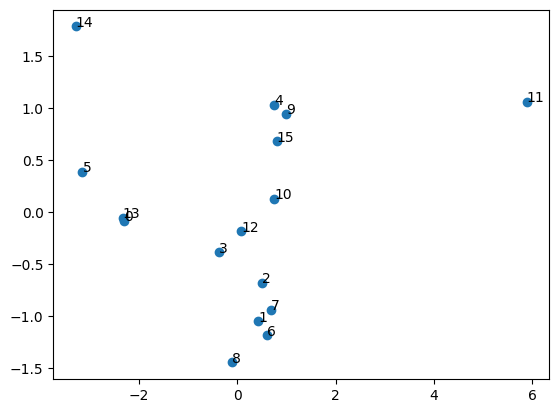

In [21]:
import matplotlib.pyplot as plt

for x in ds_train.batch(16):
  res = x['description']
  break

for i,x in enumerate(res):
  print(f"{i} -> {x.numpy().decode('utf-8')}")

for x,y in ds_train.map(process_fn).batch(16):
  res = model(x)
  z = res['pooler_output']
  break
from sklearn.decomposition import PCA
z2 = PCA(2).fit_transform(z)
plt.scatter(z2[:,0],z2[:,1])
for i,c in enumerate(z2):
  plt.annotate(str(i),c)

## NER с помощью трансформеров

Пример адаптирован из [этой главы](https://huggingface.co/learn/nlp-course/ru/chapter7/2?fw=tf) NLP-курса от HuggingFace.

Для начала установим необходимые библиотеки:

In [ ]:
%pip install datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


Будем использовать датасет [CoNLL 2003](https://github.com/LuisPHenriques/NLP-Named-Entity-Recognition-CoNLL-2003)

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Видим, что датасет содержит метки для определения части речи (POS, Part-of-Speech Tagging), NER и разбиения текста на части. Мы будем решать задачу NER:

In [ ]:
raw_datasets["train"][0]["tokens"], raw_datasets["train"][0]["ner_tags"]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 [3, 0, 7, 0, 0, 0, 7, 0, 0])

Вот как выглядят теги, имеющиеся в датасете:

In [ ]:
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

Опишем функции для преобразования имени метки в номер и наоборот:

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

Для работы модели придется токенезировать текст. Остановимся на модели BERT, и используем соответствующий токенайзер:

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

Поскольку в датасете NER-классы сопоставлены словам, а не токенам, необходимо решить задачу выравнивания идентификаторов по токенам:

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Начало нового слова!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Специальный токен
            new_labels.append(-100)
        else:
            # То же слово, что и предыдущий токен
            label = labels[word_id]
            # Если метка B-XXX, заменяем ее на I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


Соберём в одну функцию задачу токенизации и выравнивания, и получим токенизированные датасеты:

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Определим DataCollator для объединения примеров в батчи, и преобразуем датасеты в формат Tensorflow

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

tf_eval_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

Загрузим предобученную BERT-модель. При этом укажем словари для преобразования номеров меток в идентификаторы и обратно, из этих словарей модель возьмёт количество классов.

In [ ]:
from transformers import TFAutoModelForTokenClassification

model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Запустим обучение:

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

# Количество шагов обучения - это количество примеров в датасете, разделенное на размер батча, затем умноженное
# на общее количество эпох. Обратите внимание, что tf_train_dataset здесь - это разбитое на батчи tf.data.Dataset,
# а не оригинальный датасет Hugging Face, поэтому его len() уже равен num_samples // batch_size.
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)
model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=num_epochs,
)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
878/878 [==============================] - 273s 228ms/step - loss: 0.1737 - val_loss: 0.0594
Epoch 2/3
878/878 [==============================] - 197s 225ms/step - loss: 0.0466 - val_loss: 0.0558
Epoch 3/3
878/878 [==============================] - 200s 227ms/step - loss: 0.0265 - val_loss: 0.0521


Теперь опробуем модель на практике:

In [ ]:
from transformers import pipeline

# Замените это на свою собственную контрольную точку
token_classifier = pipeline(
    "token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple"
)
token_classifier("My name is Dmitry and I work at Moscow Aviation Institute in Moscow.")

[{'entity_group': 'PER',
  'score': 0.9896806,
  'word': 'Dmitry',
  'start': 11,
  'end': 17},
 {'entity_group': 'ORG',
  'score': 0.9864757,
  'word': 'Moscow Aviation Institute',
  'start': 32,
  'end': 57},
 {'entity_group': 'LOC',
  'score': 0.99525,
  'word': 'Moscow',
  'start': 61,
  'end': 67}]

## Выводы

В этом разделе мы познакомились с современными архитектурами нейросетей на основе **трансформеров**, применили их для задачи классификации текста. Аналогичным образом модели BERT можно использовать для извлечения сущностей, ответов на вопросы и других задач NLP.

Модели трансформеров представляют собой современное состояние NLP, и при возникновении задач обработки текстов, вероятно, стоит сразу экспериментировать с трансформерными моделями. Однако понимание основополагающих принципов рекуррентных нейронных сетей, о которых мы говорили, также чрезвычайно важно для создания новых продвинутых нейросетевых архитектур.